#### Introduction: Data Cleaning and Feature Engineering

Following our initial exploratory data analysis (EDA), this notebook serves as a workshop for cleaning the raw data and engineering new, potentially more predictive features. Before finalizing our repeatable `data_processing.py` script, we will use this interactive environment to:

1.  **Identify and handle outliers** that could negatively impact model performance.
2.  **Engineer new features**, such as financial ratios, which may capture more complex relationships within the data.
3.  **Validate the effectiveness** of these new features by re-examining their correlation with the `default` target.

The steps and logic validated here will form the core of our final data pre-processing pipeline.

#### Step 1: Load Data and Initial Setup

The first step is to load our libraries and the dataset.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the raw dataset
df = pd.read_csv('../data/Loan_Data.csv')

In [3]:
# Display the first few rows and check for missing values again
display(df.head())
print(df.isnull().sum())

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


#### Step 2: Identify and Handle Outliers

From the box plots in our EDA, we saw that some features like `income` and `fico_score` have outliers (the small circles above and below the whiskers). These extreme values can sometimes negatively influence a model's training.

A common and robust method to handle them is called capping, where we replace the outlier values with the maximum or minimum "acceptable" value. We'll use the Interquartile Range (IQR) method to determine these limits.

In [4]:
print("Summary Before Capping Outliers:")
display(df.describe())

# Create a copy to modify
df_cleaned = df.copy()

def cap_outliers_iqr(df, column):
    """Caps outliers in a specified column using the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"Capping '{column}' to range [{lower_bound:.2f}, {upper_bound:.2f}]")
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

# List of numerical columns to cap outliers for
# We will focus on the ones with visible outliers from the EDA
columns_to_cap = ['income', 'fico_score', 'total_debt_outstanding', 'loan_amt_outstanding']

for col in columns_to_cap:
    df_cleaned = cap_outliers_iqr(df_cleaned, col)

print("\nSummary After Capping Outliers:")
display(df_cleaned.describe())

Summary Before Capping Outliers:


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


Capping 'income' to range [16205.92, 123763.11]
Capping 'fico_score' to range [474.00, 802.00]
Capping 'total_debt_outstanding' to range [-6408.81, 21880.91]
Capping 'loan_amt_outstanding' to range [306.24, 7900.89]

Summary After Capping Outliers:


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4153.067298,8447.705867,70042.393835,4.552800,637.595000,0.185100
std,2.293890e+06,1.743846,1399.648502,5882.581895,19916.516060,1.566862,60.299492,0.388398
min,1.000324e+06,0.000000,306.241273,31.652732,16205.920558,0.000000,474.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,7900.892201,21880.905320,123763.113478,10.000000,802.000000,1.000000


**Outlier Capping Results**

By comparing the "Before" and "After" summaries, we can see the effect of our outlier capping.
* The **`min`** and **`max`** values for the capped columns (`income`, `fico_score`, etc.) have been pulled in to the calculated IQR boundaries. For example, the maximum `income` was reduced from over `148k` to `123k`, and the minimum `fico_score` was raised from `408` to `474`.
* The **`mean`** and **`std`** (standard deviation) for these columns have changed only slightly. This is a good sign—it means we have reduced the influence of extreme values without drastically altering the overall distribution of the data.

This step makes our dataset more robust and less sensitive to extreme values, which can lead to better performance for certain machine learning models.

#### Step 3: Feature Engineering

A classic feature in credit risk modeling is the debt-to-income ratio (DTI), which measures an individual's ability to manage monthly payments. A higher DTI often indicates a higher risk of default. We'll also create a loan-to-income ratio.

In [5]:
# Create a copy for feature engineering
df_featured = df_cleaned.copy()

# 1. Create Debt-to-Income Ratio
# We add a small epsilon (1e-6) to income to avoid division by zero errors if income is 0.
df_featured['debt_to_income_ratio'] = df_featured['total_debt_outstanding'] / (df_featured['income'] + 1e-6)

# 2. Create Loan-to-Income Ratio
df_featured['loan_to_income_ratio'] = df_featured['loan_amt_outstanding'] / (df_featured['income'] + 1e-6)

# Display the first few rows to see the new features
print("Dataset with new features:")
display(df_featured.head())

# Let's also look at the summary statistics for our new features
print("\nSummary of new features:")
display(df_featured[['debt_to_income_ratio', 'loan_to_income_ratio']].describe())

Dataset with new features:


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_to_income_ratio,loan_to_income_ratio
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,0.050173,0.066909
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,0.308789,0.073510
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,0.030787,0.051058
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,0.033645,0.064105
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,0.075435,0.057395



Summary of new features:


,debt_to_income_ratio,loan_to_income_ratio
count,10000.000000,10000.000000
mean,0.121038,0.059289
std,0.077764,0.010684
min,0.001953,0.012249
25%,0.068363,0.052063
50%,0.097221,0.059492
75%,0.163202,0.066602
max,0.369901,0.102103


**Feature Engineering Results**

We have successfully created two new features: `debt_to_income_ratio` and `loan_to_income_ratio`. These features provide relational context that the model might find more predictive than the raw debt and income values alone. For example, a high `debt_to_income_ratio` is a classic indicator of financial strain, regardless of the absolute income level. The statistical summary shows these new ratio features are now on a much smaller and more consistent scale than the original income and debt columns, which is beneficial for many model types.

#### Step 4: Final Feature Selection & Validation

We'll select our final set of features for the model and re-run the correlation heatmap to see how our new features relate to the `default` target. This will validate whether our feature engineering was useful.

Correlation Heatmap with New Features:


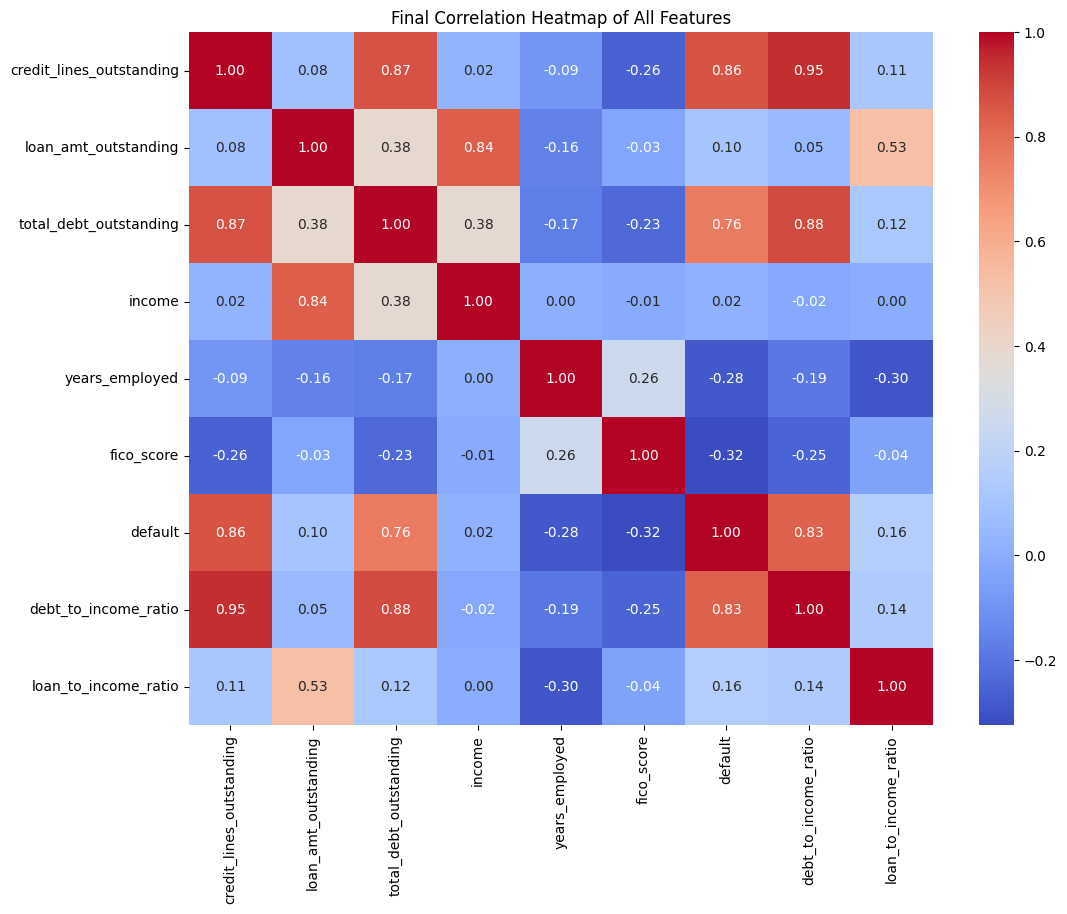


Final selected features for the model:
['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score', 'default', 'debt_to_income_ratio', 'loan_to_income_ratio']


In [6]:
# Drop the original customer_id as it is not a predictive feature
df_final = df_featured.drop('customer_id', axis=1)

# Let's re-run the correlation heatmap to include our new features
print("Correlation Heatmap with New Features:")

# Calculate the new correlation matrix
correlation_matrix_final = df_final.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 9))

# Draw the heatmap
sns.heatmap(correlation_matrix_final, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Final Correlation Heatmap of All Features')
plt.show()

print("\nFinal selected features for the model:")
print(df_final.columns.tolist())

**Final Feature Validation**

This final heatmap validates our feature engineering efforts. The newly created `debt_to_income_ratio` feature exhibits the strongest correlation with our target variable, `default`, with a coefficient of **+0.83**. This indicates that it will likely be a very powerful predictor in our models.

Note: The +0.83 correlation for DTI is unusually strong. The dataset is likely synthetic or educational, and this strong relationship was intentionally built into it. In a real-world project, this would trigger an immediate investigation to ensure there is no data leakage before proceeding.

With this, our data cleaning and feature engineering exploration is complete. We have a final set of features ready for modeling.

#### Conclusion & Finalizing the Processing Logic

This notebook has successfully established a clear and effective pre-processing strategy for our dataset.

**Key Decisions Made:**
1.  **Outlier Handling**: We have implemented an **outlier capping** strategy using the IQR method. This robustly handles extreme values in our key numerical features without drastically altering their distributions.
2.  **Feature Engineering**: We created two new features, **`debt_to_income_ratio`** and **`loan_to_income_ratio`**. The final correlation heatmap confirmed that `debt_to_income_ratio` is a very strong predictor of default, validating this step.
3.  **Feature Selection**: The `customer_id` column was identified as a non-predictive identifier and will be dropped from the final feature set.

**Next Steps:**
The logic for these validated steps—capping outliers, creating the two ratio features, and dropping the ID—is now ready to be transferred into our final, repeatable **`src/data_processing.py`** script. This ensures that the same robust pre-processing will be applied consistently before model training.